In [1]:
import math
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from celluloid import Camera

In [2]:
# Generate "Experimental" Data


torch.manual_seed(42)
t_data = torch.linspace(0, 2, 10).view(-1, 1)
true_g = 9.81
v0 = 10.0

noise_std = 0.2

# u(t) = v0*t - 0.5*g*t^2
u_data = v0 * t_data - 0.5 * true_g * t_data**2 + noise_std * torch.randn_like(t_data) # added noise

In [3]:
# Define the PINN. It's a simple NN that is used to model the value of the height. 

class GravityPINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32), nn.Tanh(),
            nn.Linear(32, 32), nn.Tanh(),
            nn.Linear(32, 1)
        )
        # We initialize g with a "wrong" guess (e.g., 5.0)
        self.g = nn.Parameter(torch.tensor([5.0], requires_grad=True))

    def forward(self, t):
        return self.net(t)

In [4]:
# Setup for logging
history = {
    'epoch': [],
    'loss_data': [],
    'loss_physics': [],
    'g_val': []
}

# Storage for the evolution of the curve
t_test = torch.linspace(0, 2, 100).view(-1, 1)
snapshots = []
snapshot_epochs = []


model = GravityPINN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
total_epochs = 20001

# Training points for the PDE (the "Bulk")
t_physics = torch.linspace(0, 2, 100).view(-1, 1).requires_grad_(True)

for epoch in range(total_epochs):
    optimizer.zero_grad()
    
    # 1. Data Loss: Match the 10 noisy measurements
    u_pred = model(t_data)
    loss_data = torch.mean((u_pred - u_data)**2)
    
    # 2. Physics Loss: Enforce u'' = -g
    u_p = model(t_physics)
    
    # Get first derivative (velocity)
    u_t = torch.autograd.grad(u_p, t_physics, torch.ones_like(u_p), create_graph=True)[0]
    # Get second derivative (acceleration)
    u_tt = torch.autograd.grad(u_t, t_physics, torch.ones_like(u_t), create_graph=True)[0]
    
    # Our PDE residual: u'' + g = 0
    loss_physics = torch.mean((u_tt + model.g)**2)

    # 3. Total Loss
    total_loss = loss_data + loss_physics
    total_loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        history['epoch'].append(epoch)
        history['loss_data'].append(loss_data.item())
        history['loss_physics'].append(loss_physics.item())
        history['g_val'].append(model.g.item())

    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Loss {total_loss.item():.4f}, Inferred g: {model.g.item():.4f}")
        
        # Switch to evaluation mode (not strictly necessary here but good practice)
        model.eval() 
        with torch.no_grad():
            u_snap = model(t_test).numpy()
            snapshots.append(u_snap)
            snapshot_epochs.append(epoch)

print(f"\nFinal Inferred g: {model.g.item():.4f} (True g: 9.81)")

Epoch 0: Loss 36.7144, Inferred g: 4.9990
Epoch 500: Loss 1.1573, Inferred g: 4.7715
Epoch 1000: Loss 0.7772, Inferred g: 4.7984
Epoch 1500: Loss 0.7520, Inferred g: 4.8728
Epoch 2000: Loss 0.7210, Inferred g: 4.9754
Epoch 2500: Loss 0.6825, Inferred g: 5.1081
Epoch 3000: Loss 0.6360, Inferred g: 5.2736
Epoch 3500: Loss 0.5825, Inferred g: 5.4731
Epoch 4000: Loss 0.5232, Inferred g: 5.7061
Epoch 4500: Loss 0.4601, Inferred g: 5.9706
Epoch 5000: Loss 0.3960, Inferred g: 6.2619
Epoch 5500: Loss 0.3321, Inferred g: 6.5742
Epoch 6000: Loss 0.2749, Inferred g: 6.9008
Epoch 6500: Loss 0.2174, Inferred g: 7.2347
Epoch 7000: Loss 0.1687, Inferred g: 7.5710
Epoch 7500: Loss 0.1278, Inferred g: 7.9049
Epoch 8000: Loss 0.0950, Inferred g: 8.2268
Epoch 8500: Loss 0.0699, Inferred g: 8.5302
Epoch 9000: Loss 0.0519, Inferred g: 8.8094
Epoch 9500: Loss 0.0404, Inferred g: 9.0584
Epoch 10000: Loss 0.0326, Inferred g: 9.2708
Epoch 10500: Loss 0.0288, Inferred g: 9.4405
Epoch 11000: Loss 0.0273, Inferre

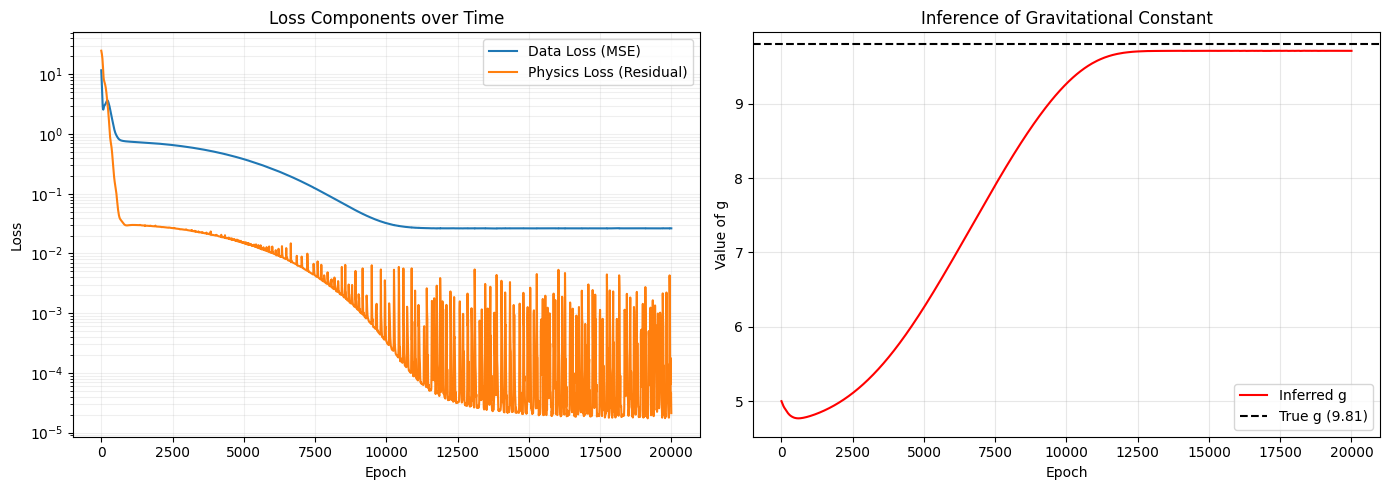

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Loss Convergence (Log Scale)
ax[0].plot(history['epoch'], history['loss_data'], label='Data Loss (MSE)')
ax[0].plot(history['epoch'], history['loss_physics'], label='Physics Loss (Residual)')
ax[0].set_yscale('log')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss Components over Time')
ax[0].legend()
ax[0].grid(True, which="both", ls="-", alpha=0.2)

# Plot 2: Parameter Inference
ax[1].plot(history['epoch'], history['g_val'], color='red', label='Inferred g')
ax[1].axhline(y=9.81, color='black', linestyle='--', label='True g (9.81)')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Value of g')
ax[1].set_title('Inference of Gravitational Constant')
ax[1].legend()
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

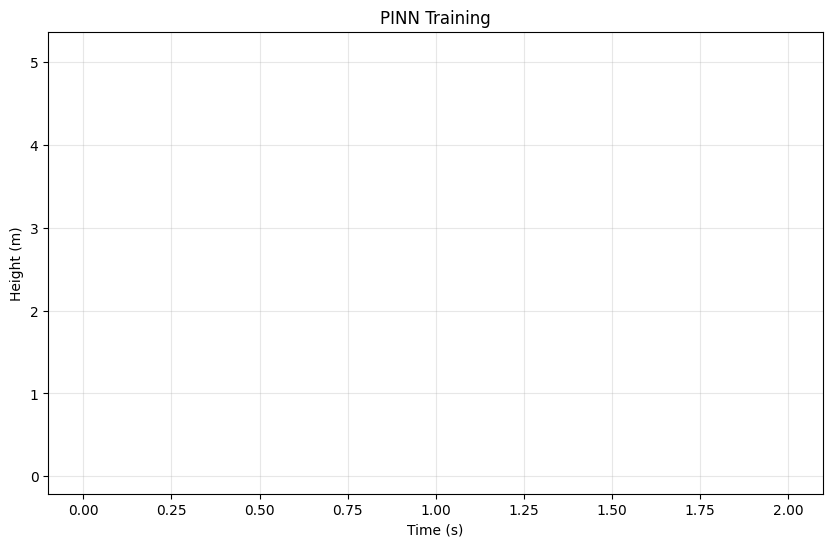

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))
camera = Camera(fig)

# Setup fixed plot elements (the "background")
plt.grid(True, alpha=0.3)
plt.xlabel("Time (s)")
plt.ylabel("Height (m)")

# Loop through your saved snapshots
# Assuming we saved g values at the same intervals as snapshots
for i, snap in enumerate(snapshots):
    # 1. Plot the static data points
    plt.scatter(t_data.numpy(), u_data.numpy(), color='black', marker='x')
    
    # 2. Plot the model's current prediction
    plt.plot(t_test.numpy(), snap, color='blue', lw=2)
    
    # 3. Dynamic Epoch Title
    # We use ax.text to place the value of g inside the plot area
    epoch = snapshot_epochs[i]
    current_g = history['g_val'][i * (500 // 10)] # Adjust index based on our logging freq
    
    plt.title(f"PINN Training")
    
    # Add a text box for the inferred gravity constant
    # (0.05, 0.95) places it in the top-left corner in 'axes' coordinates
    ax.text(0.05, 0.95, f"Inferred g: {current_g:.2f} m/s²", 
            transform=ax.transAxes, fontsize=12, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    ax.text(0.05, 0.85, f"Epoch: {epoch}", 
            transform=ax.transAxes, fontsize=12, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    # Capture the frame
    camera.snap()

# Duplicate the last frame
# If interval=200ms, then 10 snaps = 2 seconds
for _ in range(10):
    # Re-plot the EXACT same final state
    plt.scatter(t_data.numpy(), u_data.numpy(), color='black', marker='x')
    plt.plot(t_test.numpy(), snapshots[-1], color='red', lw=2) # Use last snapshot
    
    # Re-add the final text and title
    plt.title(f"PINN Training")
    ax.text(0.05, 0.95, f"Inferred g: {history['g_val'][-1]:.2f} m/s²", 
            transform=ax.transAxes, fontsize=12, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    
    ax.text(0.05, 0.85, f"Epoch: {epoch}", 
            transform=ax.transAxes, fontsize=12, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    
    camera.snap()

# Save the animation
animation = camera.animate(interval=200) # interval in ms
animation.save('pinn_learning.gif', writer='pillow')